In [3]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
library(ggplot2)
library("ggtern")
library(viridis)
library(scales)
library(rstatix)

library(RColorBrewer)

In [4]:
meta_data <- read.csv("/home/workspace/IHA_Figure_Revision//Dataset/scRNA_meta_data-2024-05-09.csv")
meta_data_subset <- meta_data %>%
    filter(Covid_exclusion == "no", sample.visitName %in% c("Flu Year 1 Day 0"))
meta_data_subset <- meta_data_subset %>%
    mutate(`Age Group` = case_when(cohort.cohortGuid == "BR1" ~ "Young", TRUE ~ "Older"))
meta_data_subset$`Age Group` <- factor(meta_data_subset$`Age Group`, levels = c("Young", "Older"))

# Read NMF score for Year 1 Day 0 Samples

In [5]:
df <- read.csv("01_NMF_CD4_T_cell_Projection/NMF_Scores_Y1D0_BRI.csv")

In [6]:
df <- df %>%
    filter(NMF_Scores %in% c("NMF0_Cytotoxic", "NMF2_Th17", "NMF5_Th2", "NMF6_Tfh", "NMF8_Cent_Mem", "NMF11_Th1")) %>%
    filter(AIFI_L3 %in% c("CM CD4 T cell", "GZMB- CD27+ EM CD4 T cell", "KLRF1- GZMB+ CD27- memory CD4 T cell", "GZMB- CD27- EM CD4 T cell"))

In [9]:
df_median <- df %>%
    group_by(AIFI_L3, pbmc_sample_id, NMF_Scores) %>%
    summarise(AverageScore_median = median(AverageScore, na.rm = TRUE)) %>%
    spread(NMF_Scores, AverageScore_median)

df_median <- left_join(df_median, meta_data_subset, by = c("pbmc_sample_id"))

`summarise()` has grouped output by 'AIFI_L3', 'pbmc_sample_id'. You can
override using the `.groups` argument.


In [10]:
df_median %>%
    group_by(AIFI_L3) %>%
    wilcox_test(NMF11_Th1 ~ cohort.cohortGuid) %>%
    mutate(adjp = p.adjust(p))
df_median %>%
    group_by(AIFI_L3) %>%
    wilcox_test(NMF5_Th2 ~ cohort.cohortGuid) %>%
    mutate(adjp = p.adjust(p))
df_median %>%
    group_by(AIFI_L3) %>%
    wilcox_test(NMF2_Th17 ~ cohort.cohortGuid) %>%
    mutate(adjp = p.adjust(p))

AIFI_L3,.y.,group1,group2,n1,n2,statistic,p,adjp
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
CM CD4 T cell,NMF11_Th1,BR1,BR2,47,45,1341,0.026600,0.053200
GZMB- CD27+ EM CD4 T cell,NMF11_Th1,BR1,BR2,47,45,658,0.001620,0.004860
GZMB- CD27- EM CD4 T cell,NMF11_Th1,BR1,BR2,47,45,1476,0.000937,0.003748
KLRF1- GZMB+ CD27- memory CD4 T cell,NMF11_Th1,BR1,BR2,44,44,1165,0.101000,0.101000


AIFI_L3,.y.,group1,group2,n1,n2,statistic,p,adjp
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
CM CD4 T cell,NMF5_Th2,BR1,BR2,47,45,679,0.00287,0.00861
GZMB- CD27+ EM CD4 T cell,NMF5_Th2,BR1,BR2,47,45,588,0.00019,0.00076
GZMB- CD27- EM CD4 T cell,NMF5_Th2,BR1,BR2,47,45,828,0.07360,0.14720
KLRF1- GZMB+ CD27- memory CD4 T cell,NMF5_Th2,BR1,BR2,44,44,1014,0.70400,0.70400


AIFI_L3,.y.,group1,group2,n1,n2,statistic,p,adjp
<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
CM CD4 T cell,NMF2_Th17,BR1,BR2,47,45,1161,4.23e-01,0.8460000
GZMB- CD27+ EM CD4 T cell,NMF2_Th17,BR1,BR2,47,45,1588,2.16e-05,0.0000864
GZMB- CD27- EM CD4 T cell,NMF2_Th17,BR1,BR2,47,45,1305,5.34e-02,0.1602000
KLRF1- GZMB+ CD27- memory CD4 T cell,NMF2_Th17,BR1,BR2,44,44,985,8.90e-01,0.8900000


In [11]:
df_median$NMF11_Th1 <- scale(df_median$NMF11_Th1, center = FALSE)
df_median$NMF5_Th2 <- scale(df_median$NMF5_Th2, center = FALSE)
df_median$NMF2_Th17 <- scale(df_median$NMF2_Th17, center = FALSE)

In [12]:
centroids <- df_median %>%
    filter(AIFI_L3 == "CM CD4 T cell") %>%
    group_by(`Age Group`) %>%
    summarize(NMF5_Th2 = median(NMF5_Th2, na.rm = TRUE), NMF11_Th1 = median(NMF11_Th1, na.rm = TRUE), NMF2_Th17 = median(NMF2_Th17, na.rm = TRUE))

In [13]:
write.csv(df_median %>%
    ungroup()%>%
    filter(AIFI_L3 == "CM CD4 T cell")%>% select(pbmc_sample_id,AIFI_L3,NMF5_Th2,NMF11_Th1,NMF2_Th17, `Age Group`) ,
          "/home/workspace/Source_Data/Fig5a.csv", row.names=FALSE)

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


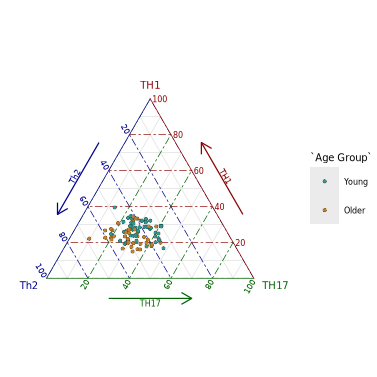

In [14]:
options(repr.plot.width = 80/25.4, repr.plot.height = 80/25.4)

p <- ggtern(data = df_median %>%
    ungroup() %>%
    filter(AIFI_L3 == "CM CD4 T cell") %>%
    arrange(desc(NMF5_Th2)), aes(NMF5_Th2, NMF11_Th1, NMF2_Th17, color = `Age Group`, fill = `Age Group`)) + 
geom_point(size = 1, shape = 21, stroke = 0.08,
    color = "black") + 
labs(x = "Th2", y = "TH1", z = "TH17") + theme_rgbw(base_size = 6) + scale_fill_manual(values = c(Older = "#bf812d", Young = "#35978f")) + scale_color_manual(values = c(Older = "#bf812d",
    Young = "#35978f"))  +
theme(tern.panel.grid.major = element_line(linewidth = 0.2), tern.axis.line = element_line(linewidth = 0.2), tern.axis.arrow = element_line(size = 1))
p
ggsave("FigureH.pdf", p, width = 80/25.4, height = 80/25.4)